# Running XGBoost on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from threeinone import cfm3in1, fimp3in1
from fpr_area import givemis,areas,erts_plot,thres

/home/shining/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/shining/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
np.set_printoptions(precision=2)

## No oversampling

In [3]:
kf = StratifiedKFold(3,shuffle=True,random_state=340)
conf_mats = [] # list to hold the confusion matrices
fimpl = [] # list to hold the feature importances
predprobs = [] # predicted probabilities

In [4]:
# Hyperparameters
num_trees = 500
random_seed = 9876
num_obj_leaf_node = 3

In [5]:
rc = 0
plt.figure()
conf_mats = []
for tr,te in kf.split(X,y):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = X[tr],X[te]
     ytrain, ytest,ytid = y[tr],y[te],idx[te]
     adclf = xgb.XGBClassifier(learning_rate=1e-3,n_estimators=500,nthread=4,max_depth=3,reg_alpha=1e-4,gamma=1e-1)
     print "[``] Fitting"
     adclf.fit(xtrain,ytrain) # My fitting
     ypredict = adclf.predict(xtest)
     conf_mats.append(confusion_matrix(ytest,ypredict))
     imp = adclf.feature_importances_
     fimpl.append(imp)
     ypp = adclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        outdf = tdf
     else:
        outdf = np.concatenate((outdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


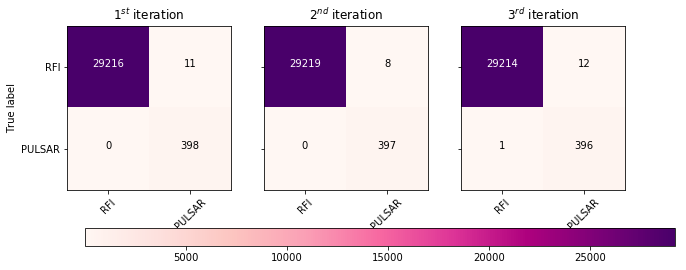

In [6]:
cfm3in1(conf_mats,clname)
plt.show()

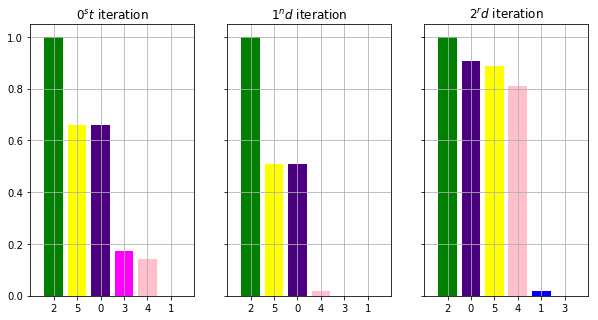

In [7]:
fimp3in1(fimpl)
plt.show()

## SMOTE
SMOTE is a way to learn imbalanced or highly skewed datasets. 
We specify a ratio of minority samples(pulsars) and majority samples(RFIs) and SMOTE using K-means and interpolation, generates new samples of the minority class until the desired ratio is achieved. 

After getting sX,sy afterever follows is the same. Fitting and plotting just with a minor change that I've prepended 'sm' to each variable to differentiate.

In [21]:
from imblearn.over_sampling import SMOTE
# this is one additional function I'll be needing
sme = SMOTE(ratio=0.5,random_state=1234) # please refer the above section for param definitions.
smX,smy = sme.fit_sample(X,y) # transforming 

In [22]:
smkf = StratifiedKFold(3,shuffle=True,random_state=340)
smconf_mats = [] # list to hold the confusion matrices
smfimpl = [] # list to hold the feature importances
smpredprobs = [] # predicted probabilities

In [23]:
rc = 0
plt.figure()
for tr,te in kf.split(smX,smy):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = smX[tr],smX[te]
     ytrain, ytest= smy[tr],smy[te]
     smadclf = xgb.XGBClassifier(learning_rate=1e-3,n_estimators=500,nthread=4,max_depth=4,reg_alpha=1e-4,gamma=1e-1)
     print "[``] Fitting"
     smadclf.fit(xtrain,ytrain) # My fitting
     ypredict = smadclf.predict(xtest)
     smconf_mats.append(confusion_matrix(ytest,ypredict))
     imp = smadclf.feature_importances_
     smfimpl.append(imp)
     ypp = smadclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        smoutdf = tdf
     else:
        smoutdf = np.concatenate((smoutdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


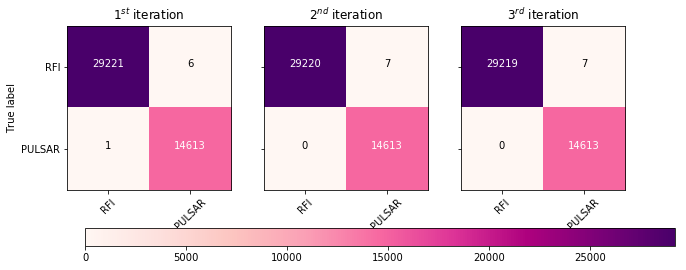

In [24]:
cfm3in1(smconf_mats,clname)
plt.show()

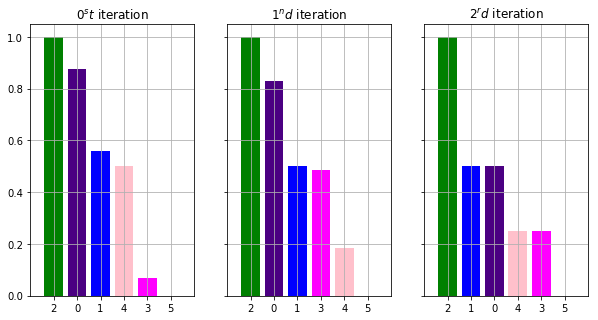

In [25]:
fimp3in1(smfimpl)
plt.show()

## FPR Analysis

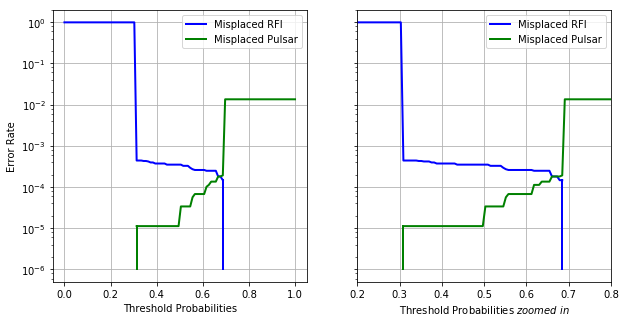

In [26]:
erts_plot(givemis(outdf,0.0,1.0),givemis(outdf,0.2,0.8),[0.2,0.8])
plt.show()

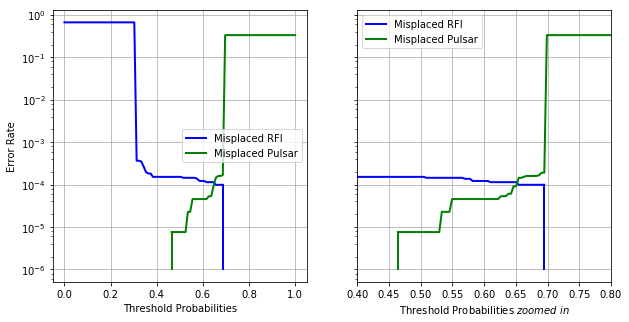

In [28]:
erts_plot(givemis(smoutdf,0.0,1.0),givemis(smoutdf,0.4,0.8),[0.4,0.8])
plt.show()

In [34]:
thres(0.4,outdf)

FPR: 0.000371320550905
FNR: 1.12521379062e-05
Recall: 0.999161073826
Precision: 0.973039215686


In [39]:
thres(0.6,outdf)

FPR: 0.000258799171843
FNR: 6.75128274372e-05
Recall: 0.994966442953
Precision: 0.980976013234


In [38]:
thres(0.68,outdf)

FPR: 0.000146277792781
FNR: 0.000180034206499
Recall: 0.986577181208
Precision: 0.989066442389


In [40]:
thres(0.5,smoutdf)

FPR: 0.000152068126521
FNR: 7.60340632603e-06
Recall: 0.999977189781
Precision: 0.999543993251


In [41]:
thres(0.6,smoutdf)

FPR: 0.000121654501217
FNR: 4.56204379562e-05
Recall: 0.999863138686
Precision: 0.999635119726


In [42]:
thres(0.65,smoutdf)

FPR: 0.000114051094891
FNR: 9.12408759124e-05
Recall: 0.999726277372
Precision: 0.999657870128


## Metric scores

In [29]:
from sklearn.metrics import *

In [30]:
print "The recall score is    {:0.4f}".format(recall_score(outdf[:,0],outdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(outdf[:,0],outdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(outdf[:,0],outdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(outdf[:,0],outdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(outdf[:,0],outdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(outdf[:,0],outdf[:,1]))

The recall score is    0.9992
The precision score is 0.9746
The accuracy is        0.9996
The f1 score is        0.9867
The logloss score is   0.0124
The MCC is             0.9866


In [31]:
print "The recall score is    {:f}".format(recall_score(smoutdf[:,0],smoutdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(smoutdf[:,0],smoutdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(smoutdf[:,0],smoutdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(smoutdf[:,0],smoutdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(smoutdf[:,0],smoutdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(smoutdf[:,0],smoutdf[:,1]))

The recall score is    0.999977
The precision score is 0.9995
The accuracy is        0.9998
The f1 score is        0.9998
The logloss score is   0.0055
The MCC is             0.9996


## Area analysis

In [32]:
areas(givemis(outdf,0.0,1.0))

mmint 1.92081950116e-05
mis1 0.304072432853
mis2 0.00415181157147


In [33]:
areas(givemis(smoutdf,0.0,1.0))

mmint 1.02146771855e-05
mis1 0.205448877461
mis2 0.102706198235
